# Model evaluation

In [1]:
import os
import numpy as np
import h5py
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [2]:
def prep_metrics(prefixes, reps, types, input_dir, epochs=None):
    metrics_dict = {}
    for i,prefix in enumerate(prefixes):
        all_metrics = []
        for j in range(reps):
            # naming convention example of 3 replicates: 1cnn_metrics.log, 2cnn_metrics.log, 3cnn_metrics.log
            path = os.path.join(input_dir, f"{j+1}{prefix}_metrics.log")
            # 0:epochs, 1: avg_val_loss, 2: avg_val_accuracy, 3: avg_train_loss, 4: avg_train_accuracy
            metrics = np.loadtxt(path, skiprows=1)
            if epochs is not None:
                if epochs < metrics.shape[0]:
                    metrics = metrics[:epochs]

                elif metrics.shape[0] < epochs: # extend length to concatenate
                    add = np.full((epochs-metrics.shape[0],5), fill_value=np.nan, dtype=np.float32)
                    metrics = np.concatenate([metrics, add])
            all_metrics.append(np.expand_dims(metrics, axis=2))
        array = np.concatenate(all_metrics, axis=2)
        metrics_dict[types[i]] = array
    return metrics_dict

In [3]:
def get_test_metrics(prefixes, dset, order, input_dir):
    all_test_metrics = []
    for i, prefix in enumerate(prefixes):
        file_path = os.path.join(input_dir, f"{prefix}_test_metrics.log")
        header = np.loadtxt(file_path, max_rows=1, dtype=str)
        idx = np.where(header == f"{dset}_avg_val_accuracy")[0]
        if len(idx) == 0:
            continue
        metrics = np.loadtxt(file_path, skiprows=1, usecols=idx)
        labels = np.loadtxt(file_path, skiprows=1, usecols=0, dtype=str)
        
        # reorder the test metrics to the order of the labels in 'order'
        test_metrics = []
        for species in order:
            if species in labels:
                idx = np.where(labels==species)[0]
                test_metrics.append(metrics[idx])
            else:
                test_metrics.append(np.array([np.nan]))
        all_test_metrics.append(np.concatenate(test_metrics))
    return np.stack(all_test_metrics, axis=-1)

In [4]:
def print_stats(metrics_dict):
    space = 13
    infos = {"header": ["Model name", "Best val corr", "Epoch", "Number"]}
    for key in metrics_dict.keys():
        # maximum average validation Pearson correlation of all replicates
        max_ = np.nanmax(metrics_dict[key][:, 2])
        location = np.where(metrics_dict[key][:,2] == max_)
        infos[key] = [key, f"{max_:.4f}", str(location[0][0]), str(location[1][0] + 1)]
        infos["header"].append(f"vs. {key}")
    
    keys = list(metrics_dict.keys())
    for key in keys:
        for k in keys:
            improvement = ((float(infos[k][1]) - float(infos[key][1]))/float(infos[key][1]))*100
            infos[k].append(f"{improvement:.2f} %")
        
    for key in infos.keys():
        if key == "header":
            table(infos[key], space, header=True)
        else:
            table(infos[key], space)
        
def table(contents, spacing, header=False):
    contents = [f"{i: <{spacing}}" if len(i) <= spacing else i[:spacing - 2] + ".." for i in contents]
    msg = "|".join(contents)
    if header:
        msg = msg + "\n" + "-" * len(msg)
    print(msg)

In [5]:
def plot_heatmap(data, cmap, xlabels, ylabels, figsize=(14, 10), dpi=100, yaxis=True, square=True, fsize=19):
    fig, ax = plt.subplots(1, sharex=True, figsize=figsize, dpi=dpi)
    cmap = copy.copy(mpl.colormaps[cmap])
    cmap.set_bad(color="silver")  # NaN values are represented by siver/grey
    im = sns.heatmap(ax=ax, data=data, cmap=cmap, vmin=0., vmax=1., square=square, annot=True, fmt=".4f",
                     cbar_kws={"ticks":np.arange(0., 1.1, 0.1), "pad": 0.05, "aspect":20, "shrink": 0.7},
                     annot_kws={'family':"Times New Roman", 'color':'black', 'fontsize': fsize-2})  # 'fontsize': 12, 
    ax.set_xticks(np.arange(len(xlabels))+0.5, labels=xlabels, fontname="Times New Roman")
    ax.tick_params(axis="x", labelrotation=90, labelsize=fsize)
    
    ax.set_yticks(np.arange(len(ylabels))+0.5, labels=ylabels, fontname="Times New Roman", style="italic")
    ax.tick_params(axis="y", labelrotation=0, labelsize=fsize)
    
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    
    # cbar
    cbar = im.collections[0].colorbar
    cbar.ax.set_ylabel("Pearson's r",rotation=-90, va="bottom", size=fsize+1, fontname="Times New Roman")
    cbar.ax.tick_params(labelsize=fsize-2, color="black", direction="out", length=5., pad=0.5, width=1.5)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")

    plt.setp(ax.spines.values(), color=None)
    plt.show()

## 1. Model overview
### 1.1 Replicates
Three replicates of each model setup tested were trained. The final test metrics are named after the following
convention ``<model_name>_<replicate_number>``. Each replicate number corresponds to a different seed that was used during training.   
    
|Replicate number|Corresponding seed|
|:---------------|:-----------------|
| 1              | 132709648        |
| 2              | 961333724        |
| 3              | 4227086911       |

### 1.2 Prefixes
|Prefix    |Final model name (best checkpoint and seed)|
|:---------|:------------------------------------------|
|cnn       |U-Net                                      |
|hy        |Hybrid                                     |
|bihy      |BiHybrid                                   |
|norm_bihy |BiHybrid_02                                |
|drop3_bihy|BiHybrid_03.1                              |
|drop5_bihy|BiHybrid_03.2                              |
|bl        |BiHybrid_04                                |
|chip      |BiHybrid_05                                |
|combi     |Combined                                   |
|+combi    |Combined_02                                |

## 2. Cross-species model evaluation

In [6]:
prefixes = ["cnn", "hy", "bihy"]
all_metrics = prep_metrics(prefixes, 3, prefixes, "../paper/results", 200) # 3 replicates
print_stats(all_metrics)

Model name   |Best val corr|Epoch        |Number       |vs. cnn      |vs. hy       |vs. bihy     
-------------------------------------------------------------------------------------------------
cnn          |0.4125       |6            |3            |0.00 %       |-5.61 %      |-15.54 %     
hy           |0.4370       |147          |2            |5.94 %       |0.00 %       |-10.52 %     
bihy         |0.4884       |104          |1            |18.40 %      |11.76 %      |0.00 %       


In [7]:
prefixes = ["bihy", "norm_bihy", "drop3_bihy", "drop5_bihy", "bl"]
all_metrics = prep_metrics(prefixes, 3, prefixes, "../paper/results", 200) # 3 replicates
print_stats(all_metrics)

Model name   |Best val corr|Epoch        |Number       |vs. bihy     |vs. norm_bihy|vs. drop3_b..|vs. drop5_b..|vs. bl       
-----------------------------------------------------------------------------------------------------------------------------
bihy         |0.4884       |104          |1            |0.00 %       |-6.38 %      |-8.47 %      |-9.12 %      |-8.25 %      
norm_bihy    |0.5217       |36           |1            |6.82 %       |0.00 %       |-2.23 %      |-2.92 %      |-1.99 %      
drop3_bihy   |0.5336       |61           |2            |9.25 %       |2.28 %       |0.00 %       |-0.71 %      |0.24 %       
drop5_bihy   |0.5374       |53           |2            |10.03 %      |3.01 %       |0.71 %       |0.00 %       |0.96 %       
bl           |0.5323       |49           |3            |8.99 %       |2.03 %       |-0.24 %      |-0.95 %      |0.00 %       


In [8]:
# the best combi metric is not comparable to the other models as it contains the average of the metrics
# for ATAC- and ChIP-seq predictions
prefixes = ["drop3_bihy", "drop5_bihy", "bl", "combi"]
all_metrics = prep_metrics(prefixes, 3, prefixes, "../paper/results", 200)
print_stats(all_metrics)

Model name   |Best val corr|Epoch        |Number       |vs. drop3_b..|vs. drop5_b..|vs. bl       |vs. combi    
---------------------------------------------------------------------------------------------------------------
drop3_bihy   |0.5336       |61           |2            |0.00 %       |-0.71 %      |0.24 %       |10.36 %      
drop5_bihy   |0.5374       |53           |2            |0.71 %       |0.00 %       |0.96 %       |11.15 %      
bl           |0.5323       |49           |3            |-0.24 %      |-0.95 %      |0.00 %       |10.09 %      
combi        |0.4835       |20           |3            |-9.39 %      |-10.03 %     |-9.17 %      |0.00 %       


In [9]:
# the best combi metric is not comparable to the other models as it contains the average of the metrics
# for ATAC- and ChIP-seq predictions
prefixes = ["chip", "combi"]
all_metrics = prep_metrics(prefixes, 3, prefixes, "../paper/results", 200)
print_stats(all_metrics)

Model name   |Best val corr|Epoch        |Number       |vs. chip     |vs. combi    
-----------------------------------------------------------------------------------
chip         |0.4387       |2            |1            |0.00 %       |-9.27 %      
combi        |0.4835       |20           |3            |10.21 %      |0.00 %       


In [10]:
prefixes = ["combi", "+combi"]
all_metrics = prep_metrics(prefixes, 3, prefixes, "../paper/results", 200)
print_stats(all_metrics)

Model name   |Best val corr|Epoch        |Number       |vs. combi    |vs. +combi   
-----------------------------------------------------------------------------------
combi        |0.4835       |20           |3            |0.00 %       |-1.87 %      
+combi       |0.4927       |22           |2            |1.90 %       |0.00 %       


In [11]:
# evaluate hold-out test set metrics
# Results marked with * also excluded flagged subsequences (unplaced scaffolds and non-nuclear sequences).
species = ["Athaliana", "Osativa"]
atac_models = ["U-Net", "Hybrid", "BiHybrid", "BiHybrid_02", "BiHybrid_03.1","BiHybrid_03.2",
               "BiHybrid_03.1*", "BiHybrid_04*", "Combined*", "Combined_02*"]
chip_models = ["BiHybrid_05*", "Combined*", "Combined_02*"]
atac_data = get_test_metrics(["U_net_rep3", "Hybrid_rep2", "BiHybrid_rep1", "BiHybrid_02_rep1", "BiHybrid_03.1_rep2",
                              "BiHybrid_03.2_rep2","BiHybrid_03.1_rep2_filtered", "BiHybrid_04_rep3", "Combined_rep3",
                              "Combined_02_rep2"],
                             "atacseq", species, "results")
chip_data = get_test_metrics(["BiHybrid_05_rep1", "Combined_rep3", "Combined_02_rep2"], "h3k4me3", species, "results")

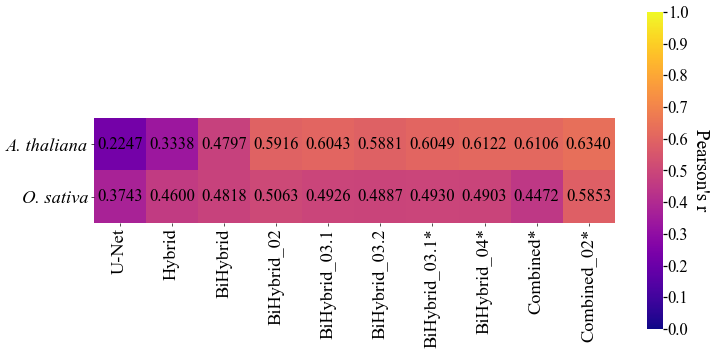

In [12]:
plot_heatmap(atac_data, "plasma", atac_models, ["A. thaliana", "O. sativa"],
             figsize=(14, 10), dpi=60, yaxis=True, square=True, fsize=22)

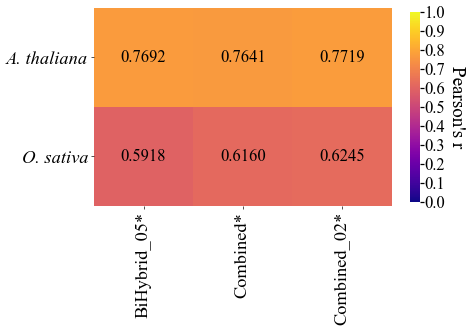

In [13]:
plot_heatmap(chip_data, "plasma", chip_models, ["A. thaliana", "O. sativa"],
             figsize=(8, 6), dpi=60, yaxis=True, square=True, fsize=22)

## 3. Intra-species and leave-one-out cross validation models
For these models, instead of training three replicates, just one model was trained.    
    
### Prefixes
|Prefix    |Decription/Final model name                                        |
|:---------|:------------------------------------------------------------------|
|achi_l1o  |Leave-one out cross validation; validation set: _A. chinensis_     |
|athali_l1o|Leave-one out cross validation; validation set: _A. thaliana_      |
|bdist_l1o |Leave-one out cross validation; validation set: _B. distachyon_    |
|bnap_l1o  |Leave-one out cross validation; validation set: _B. napus_         |
|bnat_l1o  |Leave-one out cross validation; validation set: _B. natans_        |
|bol_l1o   |Leave-one out cross validation; validation set: _B. oleracea_      |
|bra_l1o   |Leave-one out cross validation; validation set: _B. rapa_          |
|cr_l1o    |Leave-one out cross validation; validation set: _C. reinhardtii_   |
|enin_l1o  |Leave-one out cross validation; validation set: _E. nindensis_     |
|gmax_l1o  |Leave-one out cross validation; validation set: _G. max_           |
|mdom_l1o  |Leave-one out cross validation; validation set: _M. domestica_     |
|mpoly_l1o |Leave-one out cross validation; validation set: _M. polymorpha_    |
|mtrunc_l1o|Leave-one out cross validation; validation set: _M. truncatula_    |
|obra_l1o  |Leave-one out cross validation; validation set: _O. brachyantha_   |
|osat_l1o  |Leave-one out cross validation; validation set: _O. sativa_        |
|otho_l1o  |Leave-one out cross validation; validation set: _O. thomaeum_      |
|pb_l1o    |Leave-one out cross validation; validation set: _P. bretschneideri_|
|pmili_l1o |Leave-one out cross validation; validation set: _P. miliaceum_     |
|pp_l1o    |Leave-one out cross validation; validation set: _P. persica_       |
|sbi_l1o   |Leave-one out cross validation; validation set: _S. bicolor_       |
|sind_l1o  |Leave-one out cross validation; validation set: _S. indicum_       |
|sit_l1o   |Leave-one out cross validation; validation set: _S. italica_       |
|slyco_l1o |Leave-one out cross validation; validation set: _S. lycopersicum_  |
|spoly_l1o |Leave-one out cross validation; validation set: _S. polyrhiza_     |
|zmays_l1o |Leave-one out cross validation; validation set: _Z. mays_          |
|inter_10  |IS_10 (10 % of each species dataset is used for validation)        |
|inter_20  |IS_20 (20 % of each species dataset is used for validation)        |

In [14]:
def prep_single_metrics(prefixes, types, input_dir, epochs=None):
    metrics_dict = {}
    for i, prefix in enumerate(prefixes):
        path = os.path.join(input_dir, f"{prefix}_metrics.log")
        # 0:epochs, 1: avg_val_loss, 2: avg_val_accuracy, 3: avg_train_loss, 4: avg_train_accuracy
        metrics = np.loadtxt(path, skiprows=1)
        if epochs is not None:
            if epochs < metrics.shape[0]:
                metrics = metrics[:epochs]

            elif metrics.shape[0] < epochs: # extend length to concatenate
                add = np.full((epochs-metrics.shape[0],5), fill_value=np.nan, dtype=np.float32)
                metrics = np.concatenate([metrics, add])
            all_metrics.append(np.expand_dims(metrics, axis=2))
        metrics_dict[types[i]] = metrics
    return metrics_dict

In [15]:
def print_single_stats(metrics_dict):
    space = 15
    infos = {"header": ["Model name", "Best val corr", "Epoch", "Total epochs"]}
    for key in metrics_dict.keys():
        # maximum average validation Pearson correlation of all replicates
        max_ = np.nanmax(metrics_dict[key][:, 2])
        location = np.where(metrics_dict[key][:,2] == max_)
        infos[key] = [key, f"{max_:.4f}", str(int(location[0])), str(int(metrics_dict[key][:, 0][-1]))]
    
    keys = list(metrics_dict.keys())
        
    for key in infos.keys():
        if key == "header":
            table(infos[key], space, header=True)
        else:
            table(infos[key], space)
        
def table(contents, spacing, header=False):
    contents = [f"{i: <{spacing}}" if len(i) <= spacing else i[:spacing - 2] + ".." for i in contents]
    msg = "|".join(contents)
    if header:
        msg = msg + "\n" + "-" * len(msg)
    print(msg)

In [16]:
l1o = ["achi_l1o", "athali_l1o", "bdist_l1o", "bnap_l1o", "bnat_l1o", "bol_l1o", "bra_l1o", "cr_l1o", "enin_l1o",
       "gmax_l1o", "mdom_l1o", "mpoly_l1o", "mtrunc_l1o", "obra_l1o", "osat_l1o", "otho_l1o", "pb_l1o", "pmili_l1o",
       "pp_l1o", "sbi_l1o", "sind_l1o", "sit_l1o", "slyco_l1o", "spoly_l1o", "zmays_l1o", "inter_10", "inter_20"]
metrics = prep_single_metrics(l1o, l1o, "../paper/results")
print_single_stats(metrics)

Model name     |Best val corr  |Epoch          |Total epochs   
---------------------------------------------------------------
achi_l1o       |0.4251         |50             |84             
athali_l1o     |0.7083         |56             |84             
bdist_l1o      |0.6674         |18             |64             
bnap_l1o       |0.5271         |36             |63             
bnat_l1o       |0.1247         |35             |62             
bol_l1o        |0.5789         |47             |64             
bra_l1o        |0.6509         |56             |79             
cr_l1o         |-0.0379        |67             |79             
enin_l1o       |0.3956         |31             |66             
gmax_l1o       |0.5041         |38             |66             
mdom_l1o       |0.4182         |38             |64             
mpoly_l1o      |0.4474         |24             |66             
mtrunc_l1o     |0.4717         |19             |63             
obra_l1o       |0.7862         |6       